In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences #2.2.4
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
import pandas as pd 
import numpy as np 

In [3]:
from tqdm import tqdm, trange

In [4]:
import keras
keras.__version__

'2.2.4'

In [5]:
MAX_LEN = 75
bs = 32

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [7]:
torch.cuda.get_device_name(0)


'GeForce GTX 1080 Ti'

In [8]:
# load pretrained bert model 
tokenizer_chinese = BertTokenizer.from_pretrained("bert-base-chinese", do_lower_case=False)

In [9]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer_chinese.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [10]:
asia = pd.read_csv('亞洲研究院數據集/asia_institute.csv')

In [11]:
sentences = []
labels = []
for j in range(len(asia)):
    sentences2 = [i.split("'")[1] for i in asia.words[j][1:-1].split(',')]
    sentences2_len = len(sentences2)
    labels2 = [i.split("'")[1] for i in asia.tags_encoding[j][1:-1].split(',')] # 因為labels感覺有被做padding 長度不均，所以要做處理
    labels2 = labels2[:sentences2_len]
    sentences.append(sentences2)
    labels.append(labels2)

In [12]:
tag_values = ['O',
 'B_person_name',
 'M_person_name',
 'E_person_name',
 'PAD']

In [13]:
tag2idx = { 'O': 0,
           'B_person_name': 1,
           'M_person_name': 2,
           'E_person_name': 3,
           'PAD': 4}

In [14]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

In [15]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [16]:
input_ids = pad_sequences([tokenizer_chinese.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0, #　MAX_LEN
                          truncating="post", padding="post")

In [17]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [18]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [19]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=38, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=38, test_size=0.1)


In [20]:
tr_inputs = torch.tensor(tr_inputs)
tr_inputs = torch.tensor(tr_inputs).to(torch.int64)

val_inputs = torch.tensor(val_inputs)
val_inputs = torch.tensor(val_inputs).to(torch.int64)

tr_tags = torch.tensor(tr_tags)
tr_tags=torch.tensor(tr_tags, dtype=torch.long) 

val_tags = torch.tensor(val_tags)
val_tags=torch.tensor(val_tags, dtype=torch.long) 

tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)


C:\Users\User\Anaconda3\envs\torch_2\lib\site-packages\ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
C:\Users\User\Anaconda3\envs\torch_2\lib\site-packages\ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
C:\Users\User\Anaconda3\envs\torch_2\lib\site-packages\ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
C:\Users\User\Anaconda3\envs\torch_2\lib\site-packages\ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTe

In [22]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)#總資料數45081,batch_size:32,所以共有1409個batch

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)


In [23]:
import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__


'2.11.0'

In [24]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-chinese",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

In [25]:
model.cuda();

In [26]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [27]:
from transformers import get_linear_schedule_with_warmup

epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [28]:
from seqeval.metrics import f1_score, accuracy_score

In [29]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Average train loss: 0.033895605011965264
Validation loss: 0.011427349851216089
Validation Accuracy: 0.9967216019847599


Epoch:  33%|███▎      | 1/3 [06:29<12:59, 389.82s/it]

Validation F1-Score: 0.972260310093872

Average train loss: 0.007981731327909474
Validation loss: 0.009177569176859069
Validation Accuracy: 0.9978734715576821


Epoch:  67%|██████▋   | 2/3 [12:57<06:29, 389.16s/it]

Validation F1-Score: 0.9813943541488451

Average train loss: 0.003061992976819683
Validation loss: 0.010999817077292137
Validation Accuracy: 0.9981392876129718


Epoch: 100%|██████████| 3/3 [19:19<00:00, 386.41s/it]

Validation F1-Score: 0.9843300287815798



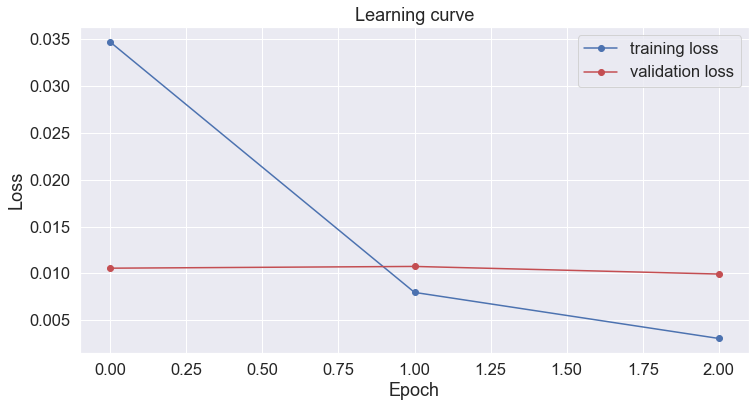

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [ ]:
# save model
import os 
PATH = os.getcwd()+str('/step1_1output_bertmode_step1_ner.pth')
torch.save(model, PATH)

# 執行到以上，下面是測試

In [130]:
test_sentence = '''中華統一促進黨總裁「白狼」張安樂及其子張瑋，
遭控收受政治獻金卻未按規定申報，還涉替張瑋成立的「華夏大地旅行社」逃漏稅，掏空兩千多萬元公司資產啊啊啊啊啊啊啊啊'''


In [30]:
test_sentence = '''夜店小王子家賢本月的KPI是載實習生妹妹下班，真的鬼'''

In [160]:
test_sentence = '''今天早上的部會抽籤，讓我很緊張，還好看到的是游騰林跟燊磊一齊出現在中獎名單上，真是阿彌陀佛'''

In [161]:
tokenized_sentence = tokenizer_chinese.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()

In [132]:
len([tokenizer_chinese.convert_ids_to_tokens(i) for i in tokenized_sentence])

512

In [162]:
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)


In [70]:
# join bpe split tokens
tokens = tokenizer_chinese.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

In [71]:
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))


O	[CLS]
O	中
O	華
O	統
O	一
O	促
O	進
O	黨
O	總
O	裁
O	「
O	白
O	狼
O	」
B_person_name	張
M_person_name	安
E_person_name	樂
O	及
O	其
O	子
B_person_name	張
E_person_name	瑋
O	，
O	遭
O	控
O	收
O	受
O	政
O	治
O	獻
O	金
O	卻
O	未
O	按
O	規
O	定
O	申
O	報
O	，
O	還
O	涉
O	替
B_person_name	張
E_person_name	瑋
O	成
O	立
O	的
O	「
O	華
O	夏
O	大
O	地
O	旅
O	行
O	社
O	」
O	逃
O	漏
O	稅
O	，
O	掏
O	空
O	兩
O	千
O	多
O	萬
O	元
O	公
O	司
O	資
O	產
O	啊
O	啊
O	啊
O	啊
O	啊
O	啊
O	啊
O	啊
O	[SEP]
